# Hello world

This example contains two parts. You will first create a simple quantum program and run it on a quantum processing unit (QPU).  Because actual quantum research requires much more robust programs, in the second section ([Scale to large numbers of qubits](#scale-to-large-numbers-of-qubits)), you will scale the simple program up to utility level.  You can also follow along with the Hello World episode of the Coding with Qiskit 1.0 video series.

<iframe width="100%" height="450" src="https://www.youtube.com/embed/93-zLTppFZw?si=whJzB_FrpuorerTv" title="Hello World" frameborder="0" allow="accelerometer; clipboard-write; encrypted-media; gyroscope; picture-in-picture" referrerpolicy="strict-origin-when-cross-origin" allowfullscreen></iframe>

## Before you begin

Follow the [Install and set up](./install-qiskit) instructions if you haven't already, including the steps to [Set up to use IBM Quantum&trade; Platform](setup-channel#set-up-to-use-ibm-quantum-platform).

It is recommended that you use the [Jupyter](https://jupyter.org/install) development environment to interact with quantum computers. Be sure to install the recommended extra visualization support (`'qiskit[visualization]'`). You'll also need the `matplotlib` package for the second part of this example.

To learn about quantum computing in general, visit the [Basics of quantum information course](https://learning.quantum.ibm.com/course/basics-of-quantum-information) in IBM Quantum Learning.

The four steps to writing a quantum program using Qiskit patterns are:

1.  Map the problem to a quantum-native format.

2.  Optimize the circuits and operators.

3.  Execute using a quantum primitive function.

4.  Analyze the results.

## Create and run a simple quantum program

### Step 1. Map the problem to a quantum-native format

In a quantum program, *quantum circuits* are the native format in which to represent quantum instructions, and *operators* represent the observables to be measured. When creating a circuit, you'll usually create a new [`QuantumCircuit`](/api/qiskit/qiskit.circuit.QuantumCircuit#quantumcircuit-class) object, then add instructions to it in sequence.

The following code cell creates a circuit that produces a *Bell state,* which is a state wherein two qubits are fully entangled with each other.

<Admonition type="note" title="Note: bit ordering">
  The Qiskit SDK uses the LSb 0 bit numbering where the $n^{th}$ digit has value $1 \ll n$ or $2^n$. For more details, see the [Bit-ordering in the Qiskit SDK](./bit-ordering) topic.
</Admonition>

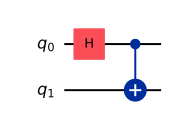

In [1]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator

# Create a new circuit with two qubits
qc = QuantumCircuit(2)

# Add a Hadamard gate to qubit 0
qc.h(0)

# Perform a controlled-X gate on qubit 1, controlled by qubit 0
qc.cx(0, 1)

# Return a drawing of the circuit using MatPlotLib ("mpl"). This is the
# last line of the cell, so the drawing appears in the cell output.
# Remove the "mpl" argument to get a text drawing.
qc.draw("mpl")

See [`QuantumCircuit`](/api/qiskit/qiskit.circuit.QuantumCircuit#quantumcircuit-class) in the documentation for all available operations.

When creating quantum circuits, you must also consider what type of data you want returned after execution. Qiskit provides two ways to return data: you can obtain a probability distribution for a set of qubits you choose to measure, or you can obtain the expectation value of an observable. Prepare your workload to measure your circuit in one of these two ways with [Qiskit primitives](./get-started-with-primitives) (explained in detail in [Step 3](#step-3-execute-using-the-quantum-primitives)).

This example measures expectation values by using the `qiskit.quantum_info` submodule, which is specified by using operators (mathematical objects used to represent an action or process that changes a quantum state). The following code cell creates six two-qubit Pauli operators: `IZ`, `IX`, `ZI`, `XI`, `ZZ`, and `XX`.

In [2]:
# Set up six different observables.
from qiskit.quantum_info import SparsePauliOp

observables_labels = ["IZ", "IX", "ZI", "XI", "ZZ", "XX"]
observables = [SparsePauliOp(label) for label in observables_labels]

<Admonition type="note" title="Operator Notation">
Here, something like the `ZZ` operator is a shorthand for the tensor product $Z\otimes Z$, which means measuring Z on qubit 1 and Z on qubit 0 together, and obtaining information about the correlation between qubit 1 and qubit 0. Expectation values like this are also typically written as $\langle Z_1 Z_0 \rangle$.

If the state is entangled, then the measurement of $\langle Z_1 Z_0 \rangle$ should be 1.
</Admonition>

### Step 2. Optimize the circuits and operators

When executing circuits on a device, it is important to optimize the set of instructions that the circuit contains and minimize the overall depth (roughly the number of instructions) of the circuit. This ensures that you obtain the best results possible by reducing the effects of error and noise. Additionally, the circuit's instructions must conform to a backend device's [Instruction Set Architecture (ISA)](./transpile#instruction-set-architecture) and must consider the device's basis gates and qubit connectivity.

The following code instantiates a real device to submit a job to and transforms the circuit and observables to match that backend's ISA.

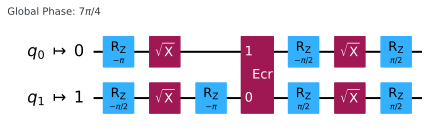

In [3]:
from qiskit_ibm_runtime import QiskitRuntimeService

# If you did not previously save your credentials, use the following line instead:
# service = QiskitRuntimeService(channel="ibm_quantum", token="<MY_IBM_QUANTUM_TOKEN>")
service = QiskitRuntimeService()

backend = service.least_busy(simulator=False, operational=True)

# Convert to an ISA circuit and layout-mapped observables.
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)

isa_circuit.draw('mpl', idle_wires=False)

### Step 3. Execute using the quantum primitives

Quantum computers can produce random results, so you usually collect a sample of the outputs by running the circuit many times. You can estimate the value of the observable by using the `Estimator` class. `Estimator` is one of two [primitives](./get-started-with-primitives); the other is `Sampler`, which can be used to get data from a quantum computer.  These objects possess a `run()` method that executes the selection of circuits, observables, and parameters (if applicable), using what's known as a [primitive unified bloc (PUB).](./primitives#sampler-v2)

In [4]:
# Construct the Estimator instance.
from qiskit_ibm_runtime import EstimatorV2 as Estimator

estimator = Estimator(mode=backend)
estimator.options.resilience_level = 1
estimator.options.default_shots = 5000

mapped_observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]

# One pub, with one circuit to run against five different observables.
job = estimator.run([(isa_circuit, mapped_observables)])

# Use the job ID to retrieve your job data later
print(f">>> Job ID: {job.job_id()}")

>>> Job ID: ct40etvezpa0008kqte0


After a job is submitted, you can wait until either the job is completed within your current python instance, or use the `job_id` to retrieve the data at a later time.  (See the [section on retrieving jobs](./monitor-job#retrieve-job-results-at-a-later-time) for details.)

After the job completes, examine its output through the job's `result()` attribute.

In [5]:
# This is the result of the entire submission.  You submitted one Pub,
# so this contains one inner result (and some metadata of its own).
job_result = job.result()

# This is the result from our single pub, which had six observables,
# so contains information on all six.
pub_result = job.result()[0]

In [6]:
# Check there are six observables.
# If not, edit the comments in the previous cell and update this test.
assert len(pub_result.data.evs) == 6

<Admonition type="note" title="Alternative: run the example using a simulator">
  When you run your quantum program on a real device, your workload must wait in a queue before it runs. To save time, you can instead use the following code to run this small workload on the [`fake_provider`](../api/qiskit-ibm-runtime/fake_provider) with the Qiskit Runtime local testing mode. Note that this is only possible for a small circuit. When you scale up in the next section, you will need to use a real device.

  ```python

  # Use the following code instead if you want to run on a simulator:

  from qiskit_ibm_runtime.fake_provider import FakeAlmadenV2
  backend = FakeAlmadenV2()
  estimator = Estimator(backend)

  # Convert to an ISA circuit and layout-mapped observables.

  pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
  isa_circuit = pm.run(qc)
  mapped_observables = [
      observable.apply_layout(isa_circuit.layout) for observable in observables
  ]

  job = estimator.run([(isa_circuit, mapped_observables)])
  result = job.result()

  # This is the result of the entire submission.  You submitted one Pub,
  # so this contains one inner result (and some metadata of its own).

  job_result = job.result()

  # This is the result from our single pub, which had five observables,
  # so contains information on all five.

  pub_result = job.result()[0]
  ```
</Admonition>

### Step 4. Analyze the results

The analyze step is typically where you might postprocess your results using, for example, measurement error mitigation or zero noise extrapolation (ZNE). You might feed these results into another workflow for further analysis or prepare a plot of the key values and data. In general, this step is specific to your problem.  For this example, plot each of the expectation values that were measured for our circuit.

The expectation values and standard deviations for the observables you specified to Estimator are accessed through the job result's `PubResult.data.evs` and `PubResult.data.stds` attributes. To obtain the results from Sampler, use the `PubResult.data.meas.get_counts()` function, which will return a `dict` of measurements in the form of bitstrings as keys and counts as their corresponding values. For more information, see [Get started with Sampler.](./get-started-with-primitives#get-started-with-sampler)

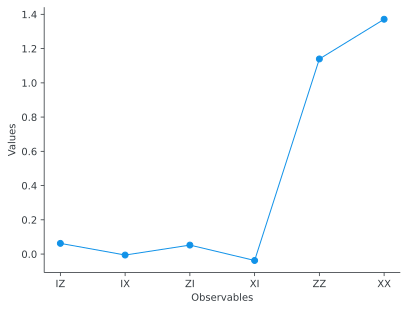

In [7]:
# Plot the result

from matplotlib import pyplot as plt

values = pub_result.data.evs

errors = pub_result.data.stds

# plotting graph
plt.plot(observables_labels, values, '-o')
plt.xlabel('Observables')
plt.ylabel('Values')
plt.show()

Notice that for qubits 0 and 1, the independent expectation values of both X and Z are 0, while the correlations (`XX` and `ZZ`) are 1. This is a hallmark of quantum entanglement.

In [8]:
# Make sure the results follow the claim the the previous markdown cell.
# This can happen when the device occasionally behaves strangely. If this cell
# fails, you may just need to run the notebook again.

_results = { obs: val for obs, val in zip(observables_labels, values) }
for _label in ["IZ", "IX", "ZI", "XI"]:
    assert abs(_results[_label]) < 0.2
for _label in ["XX", "ZZ"]:
    assert _results[_label] > 0.8

## Scale to large numbers of qubits

In quantum computing, utility-scale work is crucial for making progress in the field. Such work requires computations to be done on a much larger scale; working with circuits that might use over 100 qubits and over 1000 gates. This example demonstrates how you can accomplish utility-scale work on IBM&reg; QPUs by creating and analyzing a 100-qubit GHZ state.  It uses the Qiskit Patterns workflow and ends by measuring the expectation value $\langle Z_0 Z_i \rangle $ for each qubit.

### Step 1. Map the problem

Write a function that returns a `QuantumCircuit` that prepares an $n$-qubit GHZ state (essentially an extended Bell state), then use that function to prepare a 100-qubit GHZ state and collect the observables to be measured.

In [9]:
from qiskit import QuantumCircuit

def get_qc_for_n_qubit_GHZ_state(n: int) -> QuantumCircuit:
    """This function will create a qiskit.QuantumCircuit (qc) for an n-qubit GHZ state.

    Args:
        n (int): Number of qubits in the n-qubit GHZ state

    Returns:
        QuantumCircuit: Quantum circuit that generate the n-qubit GHZ state, assuming all qubits start in the 0 state
    """
    if isinstance(n, int) and n >= 2:
        qc = QuantumCircuit(n)
        qc.h(0)
        for i in range(n-1):
            qc.cx(i, i+1)
    else:
        raise Exception("n is not a valid input")
    return qc

# Create a new circuit with two qubits (first argument) and two classical
# bits (second argument)
n = 100
qc = get_qc_for_n_qubit_GHZ_state(n)

Next, map to the operators of interest. This example uses the `ZZ` operators between qubits to examine the behavior as they get farther apart.  Increasingly inaccurate (corrupted) expectation values between distant qubits would reveal the level of noise on the system.

In [10]:
from qiskit.quantum_info import SparsePauliOp

# ZZII...II, ZIZI...II, ... , ZIII...IZ
operator_strings = ['Z' + 'I'*i + 'Z' + 'I'*(n-2-i) for i in range(n-1)]
print(operator_strings)
print(len(operator_strings))

operators = [SparsePauliOp(operator) for operator in operator_strings]

['ZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII

### Step 2. Optimize the problem for execution on quantum hardware

Transform the circuit and observables to match the backend's ISA.

In [11]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService

# If you did not previously save your credentials, use the following line instead:
# service = QiskitRuntimeService(channel="ibm_quantum", token="<MY_IBM_QUANTUM_TOKEN>")
service = QiskitRuntimeService()

backend = service.least_busy(simulator=False, operational=True, min_num_qubits=100)
pm = generate_preset_pass_manager(optimization_level=1, backend=backend)

isa_circuit = pm.run(qc)
isa_operators_list = [op.apply_layout(isa_circuit.layout) for op in operators]

### Step 3. Execute on hardware

Submit the job and enable error suppression by using a technique to reduce errors called [dynamical decoupling.](../api/qiskit-ibm-runtime/qiskit_ibm_runtime.options.DynamicalDecouplingOptions) The resilience level specifies how much resilience to build against errors. Higher levels generate more accurate results, at the expense of longer processing times.  For further explanation of the options set in the following code, see [Configure error mitigation for Qiskit Runtime.](./configure-error-mitigation)

In [12]:
from qiskit_ibm_runtime import EstimatorOptions
from qiskit_ibm_runtime import EstimatorV2 as Estimator

options = EstimatorOptions()
options.resilience_level = 1
options.dynamical_decoupling.enable = True
options.dynamical_decoupling.sequence_type = "XY4"

# Create an Estimator object
estimator = Estimator(backend, options=options)

In [13]:
# Submit the circuit to Estimator
job = estimator.run([(isa_circuit, isa_operators_list)])
job_id = job.job_id()
print(job_id)

ct40gwvmqj7g008081vg


### Step 4. Post-process results

After the job completes, plot the results and notice that $\langle Z_0 Z_i \rangle$ decreases with increasing $i$, even though in an ideal simulation all $\langle Z_0 Z_i \rangle$ should be 1.

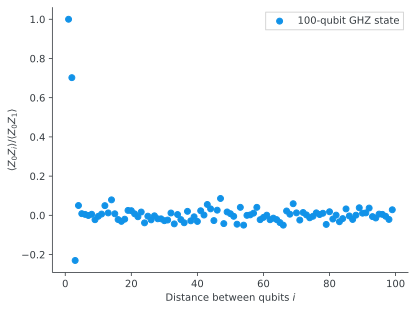

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit_ibm_runtime import QiskitRuntimeService

# data
data = list(range(1, len(operators)+1)) # Distance between the Z operators
result = job.result()[0] # Use for EstimatorV2.
values = result.data.evs # Expectation value at each Z operator. Use for Estimator V2.
# values = job.result().values # Use for EstimatorV1
values = [v / values[0] for v in values] # Normalize the expectation values to evaluate how they decay with distance.

# plotting graph
plt.scatter(data, values, marker='o', label='100-qubit GHZ state')
plt.xlabel('Distance between qubits $i$')
plt.ylabel(r'$\langle Z_0 Z_i \rangle / \langle Z_0 Z_1 \rangle $')
plt.legend()
plt.show()

The previous plot shows that as the distance between qubits increases, the signal decays because there is noise on the system.

## Next steps

<Admonition type="tip" title="Recommendations">
  -   Learn how to [build circuits](./map-problem-to-circuits) in more detail.
  -   Try one of the [workflow example tutorials.](https://learning.quantum.ibm.com/catalog/tutorials?category=workflow-example)
</Admonition>